In [1]:
!pip install pandas_datareader
!pip install seaborn
!pip install pyupbit
!pip install statsmodels
!pip install pmdarima
!pip install itertools

import os
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

import itertools
import pyupbit as pb

ERROR: Could not find a version that satisfies the requirement itertools
ERROR: No matching distribution found for itertools


In [2]:
df=pb.get_ohlcv("KRW-BTC",interval="day", count=4310)
df

,open,high,low,close,volume,value
2017-09-25 09:00:00+09:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00+09:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00+09:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00+09:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2022-05-27 09:00:00+09:00,37662000.0,37889000.0,36413000.0,36837000.0,4373.885371,1.620369e+11
2022-05-28 09:00:00+09:00,36862000.0,37373000.0,36613000.0,37034000.0,1931.845973,7.136116e+10
2022-05-29 09:00:00+09:00,37033000.0,37620000.0,36825000.0,37380000.0,1712.650146,6.369122e+10
2022-05-30 09:00:00+09:00,37415000.0,39989000.0,37230000.0,39550000.0,5467.460037,2.112747e+11


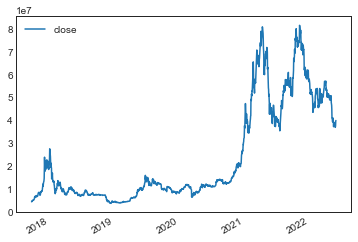

In [3]:
bitcoin_df= df.loc[:,['close']] #사용할 컬럼만 추출
bitcoin_df
fig = bitcoin_df.plot()

In [4]:
# Train Test = 8:2
from sklearn.model_selection import train_test_split
bitcoin_data_train, bitcoin_data_test = train_test_split(bitcoin_df, test_size=0.2, shuffle=False)
print(bitcoin_data_train)
print(bitcoin_data_test)

                                close
2017-09-25 09:00:00+09:00   4322000.0
2017-09-26 09:00:00+09:00   4321000.0
2017-09-27 09:00:00+09:00   4657000.0
2017-09-28 09:00:00+09:00   4586000.0
2017-09-29 09:00:00+09:00   4657000.0
...                               ...
2021-06-19 09:00:00+09:00  42088000.0
2021-06-20 09:00:00+09:00  41842000.0
2021-06-21 09:00:00+09:00  37393000.0
2021-06-22 09:00:00+09:00  37784000.0
2021-06-23 09:00:00+09:00  39077000.0

[1368 rows x 1 columns]
                                close
2021-06-24 09:00:00+09:00  40098000.0
2021-06-25 09:00:00+09:00  37152000.0
2021-06-26 09:00:00+09:00  37629000.0
2021-06-27 09:00:00+09:00  39985000.0
2021-06-28 09:00:00+09:00  39959000.0
...                               ...
2022-05-27 09:00:00+09:00  36837000.0
2022-05-28 09:00:00+09:00  37034000.0
2022-05-29 09:00:00+09:00  37380000.0
2022-05-30 09:00:00+09:00  39550000.0
2022-05-31 09:00:00+09:00  39812000.0

[342 rows x 1 columns]


// 개략적인 모델 구축

train, test data를 먼저 스플릿/
추후 검정을 위해 분리/
타임 시리즈 데이터이기 때문에 shuffle은 하지 않는다./
뒷단에 20%가 예측에 활용될 수 있도록 구성

- test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
- shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
- stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
- random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.


In [5]:
#n_obs= 20
#bitcoin_data_train, bitcoin_data_test = bitcoin_df[0:-n_obs], bitcoin_df[-n_obs:]
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(bitcoin_df)

---- Adfuller ----
ADF Statistic: -1.348691
p-value: 0.6066125143
Lag: 5
observation: 1704
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [6]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                                close
2017-09-25 09:00:00+09:00   4322000.0
2017-09-26 09:00:00+09:00   4321000.0
2017-09-27 09:00:00+09:00   4657000.0
2017-09-28 09:00:00+09:00   4586000.0
2017-09-29 09:00:00+09:00   4657000.0
...                               ...
2021-06-19 09:00:00+09:00  42088000.0
2021-06-20 09:00:00+09:00  41842000.0
2021-06-21 09:00:00+09:00  37393000.0
2021-06-22 09:00:00+09:00  37784000.0
2021-06-23 09:00:00+09:00  39077000.0

[1368 rows x 1 columns]
                                close
2021-06-24 09:00:00+09:00  40098000.0
2021-06-25 09:00:00+09:00  37152000.0
2021-06-26 09:00:00+09:00  37629000.0
2021-06-27 09:00:00+09:00  39985000.0
2021-06-28 09:00:00+09:00  39959000.0
...                               ...
2022-05-27 09:00:00+09:00  36837000.0
2022-05-28 09:00:00+09:00  37034000.0
2022-05-29 09:00:00+09:00  37380000.0
2022-05-30 09:00:00+09:00  39550000.0
2022-05-31 09:00:00+09:00  39812000.0

[342 rows x 1 columns]


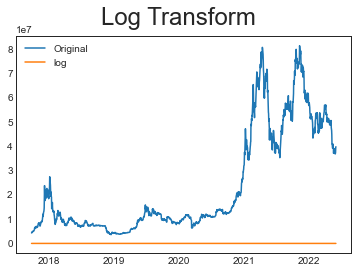

In [7]:
import numpy as np
log_bitcoin_data_train = bitcoin_data_train.copy()
log_bitcoin_data_train =np.log(bitcoin_df) #로그변환
plt.plot(bitcoin_df, label='Original')
plt.plot(log_bitcoin_data_train,label='log')
plt.suptitle("Log Transform", size= 24)
plt.legend()
plt.show()

In [8]:
diff_bitcoin_data_train = log_bitcoin_data_train.copy() #차분
diff_bitcoin_data_train = diff_bitcoin_data_train.diff()
diff_bitcoin_data_train = diff_bitcoin_data_train.dropna() #결측치 제거
print('##### Raw Data #####')
print(bitcoin_data_train)
print('##### Differenced Data #####')
print(diff_bitcoin_data_train)

##### Raw Data #####
                                close
2017-09-25 09:00:00+09:00   4322000.0
2017-09-26 09:00:00+09:00   4321000.0
2017-09-27 09:00:00+09:00   4657000.0
2017-09-28 09:00:00+09:00   4586000.0
2017-09-29 09:00:00+09:00   4657000.0
...                               ...
2021-06-19 09:00:00+09:00  42088000.0
2021-06-20 09:00:00+09:00  41842000.0
2021-06-21 09:00:00+09:00  37393000.0
2021-06-22 09:00:00+09:00  37784000.0
2021-06-23 09:00:00+09:00  39077000.0

[1368 rows x 1 columns]
##### Differenced Data #####
                              close
2017-09-26 09:00:00+09:00 -0.000231
2017-09-27 09:00:00+09:00  0.074885
2017-09-28 09:00:00+09:00 -0.015363
2017-09-29 09:00:00+09:00  0.015363
2017-09-30 09:00:00+09:00  0.049843
...                             ...
2022-05-27 09:00:00+09:00 -0.022149
2022-05-28 09:00:00+09:00  0.005334
2022-05-29 09:00:00+09:00  0.009299
2022-05-30 09:00:00+09:00  0.056430
2022-05-31 09:00:00+09:00  0.006603

[1709 rows x 1 columns]


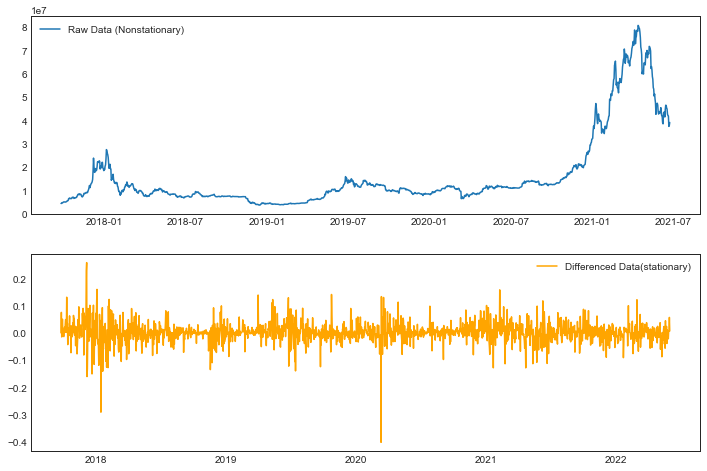

In [9]:
# Differenced data plot

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(bitcoin_data_train['close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_bitcoin_data_train, 'orange') #첫번째 차분 (t- (t-1))
plt.legend(['Differenced Data(stationary)'])
plt.show()

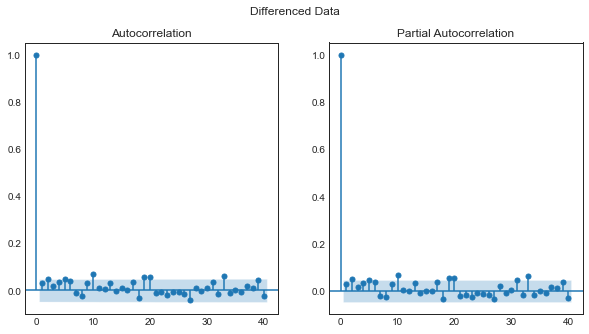

In [10]:
fig, ax= plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_bitcoin_data_train.values.squeeze(), lags=40, ax=ax[1]);

In [11]:
import matplotlib.pyplot as plt #adf테스트를 먼저해서 정상인지 확인
from statsmodels.tsa.stattools import adfuller

def ADF(bitcoin_df): #ADF검정 
    result = adfuller(bitcoin_df, autolag="AIC")
    
    print('---- Adfuller ----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' %result[3])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF(diff_bitcoin_data_train)

---- Adfuller ----
ADF Statistic: -11.340783
p-value: 0.0000000000
Lag: 9
observation: 1699
Critical values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [12]:
#파라미터 Search

auto_arima_model = auto_arima(bitcoin_data_train, start_p=1, start_q=1,
                             max_p=3, max_q=3,seasona=False,
                             d=1,
                             trace= True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=41527.079, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=41521.110, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=41522.358, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=41513.238, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=41520.673, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=41517.215, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=41519.302, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=41513.070, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=41521.377, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=41518.705, Time=0.48 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=41514.649, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=41512.449, Time=0.79 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=41512.570, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=41510.868, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=41511.784, Time=0.93

In [13]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1368
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -20749.434
Date:                Tue, 31 May 2022   AIC                          41510.868
Time:                        13:15:56   BIC                          41542.190
Sample:                             0   HQIC                         41522.591
                               - 1368                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.045e+04   4.03e+04      0.507      0.612   -5.86e+04    9.95e+04
ar.L1         -0.4408      0.107     -4.128      0.000      -0.650      -0.232
ar.L2          0.0626      0.018      3.578      0.000       0.028       0.097
ar.L3          0.1042      0.013      8.076      0.000       0.079       0.130
ma.L1          0.5189      0.106      4.898      0.000       0.311       0.727
sigma2      8.994e+11      0.009   1.03e+14      0.000    8.99e+11    8.99e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16703.17
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.30   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+29. Standard errors may be unstable.
"""

In [14]:
print(bitcoin_data_train)
print(bitcoin_data_test)

                                close
2017-09-25 09:00:00+09:00   4322000.0
2017-09-26 09:00:00+09:00   4321000.0
2017-09-27 09:00:00+09:00   4657000.0
2017-09-28 09:00:00+09:00   4586000.0
2017-09-29 09:00:00+09:00   4657000.0
...                               ...
2021-06-19 09:00:00+09:00  42088000.0
2021-06-20 09:00:00+09:00  41842000.0
2021-06-21 09:00:00+09:00  37393000.0
2021-06-22 09:00:00+09:00  37784000.0
2021-06-23 09:00:00+09:00  39077000.0

[1368 rows x 1 columns]
                                close
2021-06-24 09:00:00+09:00  40098000.0
2021-06-25 09:00:00+09:00  37152000.0
2021-06-26 09:00:00+09:00  37629000.0
2021-06-27 09:00:00+09:00  39985000.0
2021-06-28 09:00:00+09:00  39959000.0
...                               ...
2022-05-27 09:00:00+09:00  36837000.0
2022-05-28 09:00:00+09:00  37034000.0
2022-05-29 09:00:00+09:00  37380000.0
2022-05-30 09:00:00+09:00  39550000.0
2022-05-31 09:00:00+09:00  39812000.0

[342 rows x 1 columns]


In [15]:
prediction = auto_arima_model.predict(len(bitcoin_data_test),return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(bitcoin_data_test.index)
predict_index[0]

Timestamp('2021-06-24 09:00:00+0900', tz='대한민국 표준시')

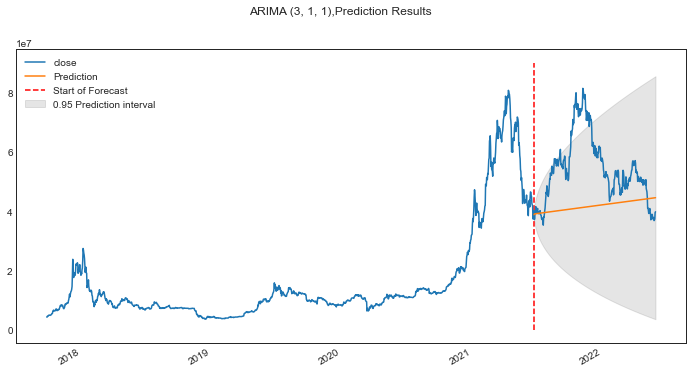

In [16]:
fig, ax = plt.subplots(figsize= (12, 6))
bitcoin_df.plot(ax=ax);
ax.vlines('2021-06-23',0,90000000.0, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

정확하게 잡아내기는 어려웠지만 제공하는 프레딕션 인터벌 안에 실제 테스트 셋이 포함되어 있는 것을 알 수 있었습니다.                                                                                                                                          

2022/05/26
- 2022년 1월부터로 트레이닝 시켜보기 /in[16]확인해보기
- 환율같은 거 넣고 해보기 